Plot the exported NenuFAR dynamic spectra data

In [1]:
import warnings
warnings.filterwarnings('ignore')

from nenupy.io import Spectra
from nenupy.io.tf import TFTask, TFPipeline
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.collections import QuadMesh
import astropy.units as u
from astropy.time import Time
from datetime import datetime, timedelta
from sunpy.timeseries import TimeSeries
from sunpy.net import Fido, attrs as a
from stixpy.net.client import STIXClient  # This registers the STIX client with Fido
from stixpy.product import Product

In [2]:
mydate = '20250325'
year, month, day = mydate[:4], mydate[4:6], mydate[6:]

data_dir = '/databf/nenufar-tf/LT11'
obs_dir  = f'{mydate}_091200_{mydate}_145000_SUN_TRACKING'
full_data = False
stokes_param = 'V'
start_time            = f'{year}-{month}-{day}T12:21:00'
end_time              = f'{year}-{month}-{day}T13:12:00'
# what_is_this_spectrum = 'typeIII_G4'
what_is_this_spectrum = 'typeII'

figsize = [7,4]

spectra_files = sorted(glob.glob(f'{data_dir}/{year}/{month}/{obs_dir}/*.spectra'))

low_freq_path  = [ file for file in spectra_files if file.endswith('_0.spectra') ][0]
high_freq_path = [ file for file in spectra_files if file.endswith('_1.spectra') ][0]
print(low_freq_path, high_freq_path, sep='\n')

/databf/nenufar-tf/LT11/2025/03/20250325_091200_20250325_145000_SUN_TRACKING/SUN_TRACKING_20250325_091237_0.spectra
/databf/nenufar-tf/LT11/2025/03/20250325_091200_20250325_145000_SUN_TRACKING/SUN_TRACKING_20250325_091237_1.spectra


In [3]:
low_data_i = Spectra(filename=low_freq_path)

if not full_data:
    low_data_i = low_data_i.get(stokes=stokes_param, tmin=start_time, tmax=end_time, ignore_volume_warning=True)
    # low_data_i.plot(figsize=figsize, title=f'Stokes {stokes_param}, default pipeline configuration')
else:
    low_data_i = low_data_i.get(stokes=stokes_param, ignore_volume_warning=True)
    # low_data_i.plot(figsize=figsize, title=f'Stokes {stokes_param}, default pipeline configuration')

2025-05-19 14:11:38 | INFO: Reading /databf/nenufar-tf/LT11/2025/03/20250325_091200_20250325_145000_SUN_TRACKING/SUN_TRACKING_20250325_091237_0.spectra...
2025-05-19 14:11:38 | INFO: 	/databf/nenufar-tf/LT11/2025/03/20250325_091200_20250325_145000_SUN_TRACKING/SUN_TRACKING_20250325_091237_0.spectra has been correctly parsed.
2025-05-19 14:11:38 | INFO: Checking for missing data (can take up to 1 min)...
2025-05-19 14:11:39 | INFO: 	There are 3/22914 blocks containing missing data and/or wrong time information.
2025-05-19 14:11:39 | INFO: Computing time-frequency axes...
2025-05-19 14:11:39 | INFO: Re-organize data into Jones matrices...
2025-05-19 14:11:39 | INFO: 	Convert data to Dask array
2025-05-19 14:11:39 | INFO: Data loaded.
2025-05-19 14:11:39 | INFO: Selecting times (between 2025-03-25T12:21:00.000 and 2025-03-25T13:12:00.000)...
2025-05-19 14:11:39 | INFO: 	145913 time samples selected.
2025-05-19 14:11:39 | INFO: Selecting frequencies (between 21.6796875 MHz and 59.1796875 M

In [4]:
high_data_i = Spectra(filename=high_freq_path)

if not full_data:
    high_data_i = high_data_i.get(stokes=stokes_param, tmin=start_time, tmax=end_time, ignore_volume_warning=True)
    # high_data_i.plot(figsize=figsize, title=f'Stokes {stokes_param}, default pipeline configuration')
else:
    high_data_i = high_data_i.get(stokes=stokes_param, ignore_volume_warning=True)
    # high_data_i.plot(figsize=figsize, title=f'Stokes {stokes_param}, default pipeline configuration')

2025-05-19 14:11:44 | INFO: Reading /databf/nenufar-tf/LT11/2025/03/20250325_091200_20250325_145000_SUN_TRACKING/SUN_TRACKING_20250325_091237_1.spectra...
2025-05-19 14:11:44 | INFO: 	/databf/nenufar-tf/LT11/2025/03/20250325_091200_20250325_145000_SUN_TRACKING/SUN_TRACKING_20250325_091237_1.spectra has been correctly parsed.
2025-05-19 14:11:44 | INFO: Checking for missing data (can take up to 1 min)...
2025-05-19 14:11:58 | INFO: 	There are 2/15276 blocks containing missing data and/or wrong time information.
2025-05-19 14:11:58 | INFO: Computing time-frequency axes...
2025-05-19 14:11:58 | INFO: Re-organize data into Jones matrices...
2025-05-19 14:11:58 | INFO: 	Convert data to Dask array
2025-05-19 14:11:58 | INFO: Data loaded.
2025-05-19 14:11:58 | INFO: Selecting times (between 2025-03-25T12:21:00.000 and 2025-03-25T13:12:00.000)...
2025-05-19 14:11:58 | INFO: 	145913 time samples selected.
2025-05-19 14:11:58 | INFO: Selecting frequencies (between 59.1796875 MHz and 84.1796875 M

In [5]:
low_times  = np.array([datetime.utcfromtimestamp(t) for t in low_data_i.time.unix])
high_times = np.array([datetime.utcfromtimestamp(t) for t in high_data_i.time.unix])

In [6]:
df_nenufar_low = pd.DataFrame(data=np.squeeze(low_data_i.data), index=low_times, columns=low_data_i.freq.to_value('MHz'))
df_nenufar_low.index.name   = 'Time'
df_nenufar_low.columns.name = 'Frequency'
df_nenufar_low.head()

Frequency,21.582031,21.588135,21.594238,21.600342,21.606445,21.612549,21.618652,21.624756,21.630859,21.636963,...,59.020996,59.027100,59.033203,59.039307,59.045410,59.051514,59.057617,59.063721,59.069824,59.075928
Time,,,,,,,,,,,,,,,,,,,,,
2025-03-25 12:20:59.997704,-5.615917e+10,-5.125514e+08,2.101778e+09,5.218709e+08,9.887342e+09,3.116873e+11,2.201774e+11,2.189993e+09,3.952684e+07,2.717575e+07,...,5.896476e+06,-1.446209e+06,7.580697e+06,3.037951e+06,2.606863e+06,1.120263e+04,7.550605e+05,-3.529240e+06,1.214503e+05,3.945796e+06
2025-03-25 12:21:00.018675,-7.173277e+10,-7.081506e+08,4.231025e+09,1.123040e+09,1.159153e+10,3.820995e+11,2.683694e+11,2.695803e+09,-2.006870e+07,1.950413e+07,...,1.303714e+07,6.981971e+06,1.351723e+06,-2.544476e+06,3.797246e+06,3.103587e+06,1.454304e+06,6.432502e+06,9.594656e+06,9.637134e+06
2025-03-25 12:21:00.039647,-8.479523e+10,-2.377505e+09,5.185115e+09,1.377791e+09,1.642802e+10,5.381046e+11,3.774806e+11,4.015134e+09,2.417364e+07,1.653099e+07,...,-5.883873e+06,3.373024e+06,-1.098003e+06,-6.636462e+06,-4.632314e+06,-1.054698e+07,-1.171624e+07,-8.823932e+06,-5.298444e+05,7.871957e+05
2025-03-25 12:21:00.060618,-9.293725e+10,-2.788018e+09,2.409998e+09,5.966797e+08,2.191619e+10,6.707419e+11,4.651606e+11,4.470048e+09,3.871252e+06,5.614736e+07,...,3.490149e+06,-1.255629e+06,-3.160690e+06,-2.269978e+06,-2.722885e+06,9.042125e+05,7.973617e+05,-7.354265e+06,1.116912e+06,-7.634442e+05
2025-03-25 12:21:00.081590,-1.041810e+11,-3.177688e+09,7.322863e+08,2.796326e+08,2.605822e+10,8.271980e+11,5.760066e+11,5.533601e+09,-2.921039e+07,2.062651e+07,...,8.205848e+06,9.137302e+06,-5.934218e+05,-1.388785e+07,-8.939358e+06,-2.289798e+06,3.165789e+06,7.475670e+06,9.541744e+06,6.981775e+06


In [7]:
df_nenufar_high = pd.DataFrame(data=np.squeeze(high_data_i.data), index=high_times, columns=high_data_i.freq.to_value('MHz'))
df_nenufar_high.index.name   = 'Time'
df_nenufar_high.columns.name = 'Frequency'
df_nenufar_high.head()

Frequency,59.082031,59.088135,59.094238,59.100342,59.106445,59.112549,59.118652,59.124756,59.130859,59.136963,...,84.020996,84.027100,84.033203,84.039307,84.045410,84.051514,84.057617,84.063721,84.069824,84.075928
Time,,,,,,,,,,,,,,,,,,,,,
2025-03-25 12:20:59.997724,6.993689e+06,4.708385e+03,4.442536e+06,3.481467e+06,8.172135e+06,5.487342e+06,5.254891e+06,-1.434059e+06,-6.234634e+05,7.398729e+06,...,-120824.083000,222637.647474,457278.464459,-88126.281397,-265325.119501,56564.224265,-21496.352099,263172.273859,547478.803504,-182887.903936
2025-03-25 12:21:00.018696,-3.985668e+06,-5.685698e+06,-5.785555e+06,-2.590008e+06,-7.202216e+06,5.531604e+06,3.470587e+05,-4.927637e+06,3.291330e+06,3.017832e+06,...,402321.908820,189357.673745,-380175.947201,26169.938295,-7844.396355,329582.933244,321524.716768,46901.922268,116931.760836,-145030.623319
2025-03-25 12:21:00.039667,3.465445e+06,1.295500e+06,1.303653e+06,3.733341e+06,7.571004e+06,2.207126e+06,-5.848314e+06,-3.288958e+06,1.247137e+06,2.882883e+06,...,-147825.404689,28111.675551,-62163.227795,48480.921272,201168.305674,354941.598061,47226.839709,-5520.255267,307883.747303,-79978.327180
2025-03-25 12:21:00.060639,-1.558442e+06,2.162033e+06,-5.171013e+06,-5.694878e+06,-4.991809e+06,1.498097e+06,-5.278882e+05,4.440538e+05,6.191126e+06,-2.602659e+06,...,235863.303993,743612.940266,-14677.821917,-73291.816450,-310293.431679,68597.630205,72463.840128,385559.615042,403881.310985,364888.743754
2025-03-25 12:21:00.081610,-1.403525e+06,-2.940804e+06,-6.630445e+06,-5.595590e+06,2.043468e+06,-4.207162e+06,-1.000307e+06,-3.702276e+05,2.421785e+06,2.720665e+06,...,585394.565263,50428.283849,-491334.928301,-127729.164920,158042.182178,-55425.147637,-399773.785433,-311190.359269,689908.756622,613985.270321


## Remapping to a new time grid without filling internal NaNs in the raw data

In [8]:
if df_nenufar_low.shape[0] < df_nenufar_high.shape[0]:
    print('High-freq dataset has more time steps than the low-freq dataset ..\nGrid remapping is needed ..')
    
    # Interpolate the high dataset onto the low dataset's time index
    df_nenufar_high_on_low_grid = df_nenufar_high.reindex(df_nenufar_low.index, method='nearest', tolerance='30ms')

    # Ensure both now have the same time index and shape
    assert df_nenufar_high_on_low_grid.shape[0] == df_nenufar_low.shape[0]
    assert all(df_nenufar_high_on_low_grid.index == df_nenufar_low.index)

    # Combine along columns
    df_combined = pd.concat([df_nenufar_low, df_nenufar_high_on_low_grid], axis=1)

elif df_nenufar_low.shape[0] > df_nenufar_high.shape[0]:
    print('Low-freq dataset has more time steps than the high-freq dataset ..\nGrid remapping is needed ..')
    
    # Interpolate the low dataset onto the high dataset's time index
    df_nenufar_low_on_high_grid = df_nenufar_low.reindex(df_nenufar_high.index, method='nearest', tolerance='30ms')
    
    # Ensure both now have the same time index and shape
    assert df_nenufar_low_on_high_grid.shape[0] == df_nenufar_high.shape[0]
    assert all(df_nenufar_low_on_high_grid.index == df_nenufar_high.index)
    
    # Combine along columns
    df_combined = pd.concat([df_nenufar_low_on_high_grid, df_nenufar_high], axis=1)

else:
    if not (df_nenufar_low.index == df_nenufar_high.index).all():
        print('Both low and high frequency datasets have the same shape, but misaligned.\nRemapping needed.')
        
        # Interpolate the high dataset onto the low dataset's time index
        df_nenufar_high_on_low_grid = df_nenufar_high.reindex(df_nenufar_low.index, method='nearest', tolerance='30ms')
        
        # Ensure both now have the same time index and shape
        assert df_nenufar_high_on_low_grid.shape[0] == df_nenufar_low.shape[0]
        assert all(df_nenufar_high_on_low_grid.index == df_nenufar_low.index)
        
        # Combine along columns
        df_combined = pd.concat([df_nenufar_low, df_nenufar_high_on_low_grid], axis=1)

    else:
        print('Both low and high frequency datasets have the same shape and are aligned.\nNo remapping needed.')
        
        # Combine along columns
        df_combined = pd.concat([df_nenufar_low, df_nenufar_high], axis=1)

df_combined = 10 * np.log10(df_combined) # Convert the amplitude to decibels

Both low and high frequency datasets have the same shape, but misaligned.
Remapping needed.


In [ ]:
# # Sanity check ...
# fig = plt.figure(figsize=[10,8])

# ax = fig.add_subplot(211)
# high_dyspec = 10*np.log10(df_nenufar_high.T)
# pc = ax.pcolormesh(df_nenufar_high.index, df_nenufar_high.columns, high_dyspec,
#                    vmin=np.nanpercentile(high_dyspec, 7), vmax=np.nanpercentile(high_dyspec, 99.97),
#                    shading='auto', cmap='Spectral_r')
# fig.colorbar(pc, ax=ax, pad=0.02, label='dB')
# ax.set_ylabel('Frequency (MHz)')
# ax.xaxis_date()
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))
# ax.set_xlabel(f'Time (MM:SS) starting from {low_times[0].time().hour}:00:00 UT')

# ax = fig.add_subplot(212)
# low_dyspec = 10*np.log10(df_nenufar_low.T)
# pc = ax.pcolormesh(df_nenufar_low.index, df_nenufar_low.columns, low_dyspec,
#                    vmin=np.nanpercentile(low_dyspec, 7), vmax=np.nanpercentile(low_dyspec, 99.97),
#                    shading='auto', cmap='Spectral_r')
# fig.colorbar(pc, ax=ax, pad=0.02, label='dB')
# ax.set_ylabel('Frequency (MHz)')
# ax.xaxis_date()
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))
# ax.set_xlabel(f'Time (MM:SS) starting from {low_times[0].time().hour}:00:00 UT')

# fig.tight_layout()
# plt.show()

In [ ]:
# # Sanity check ...
# differences = np.abs(df_nenufar_low.index.values - df_nenufar_high.index.values)
# print(f'Max time difference: {differences.max()}')

In [ ]:
print(df_combined.isna().sum().sum())  # Should be zero
print(df_combined.shape)
print(df_nenufar_high.shape)
print(df_nenufar_low.shape)

## Show the full-resolution of NenuFAR radio spectrum

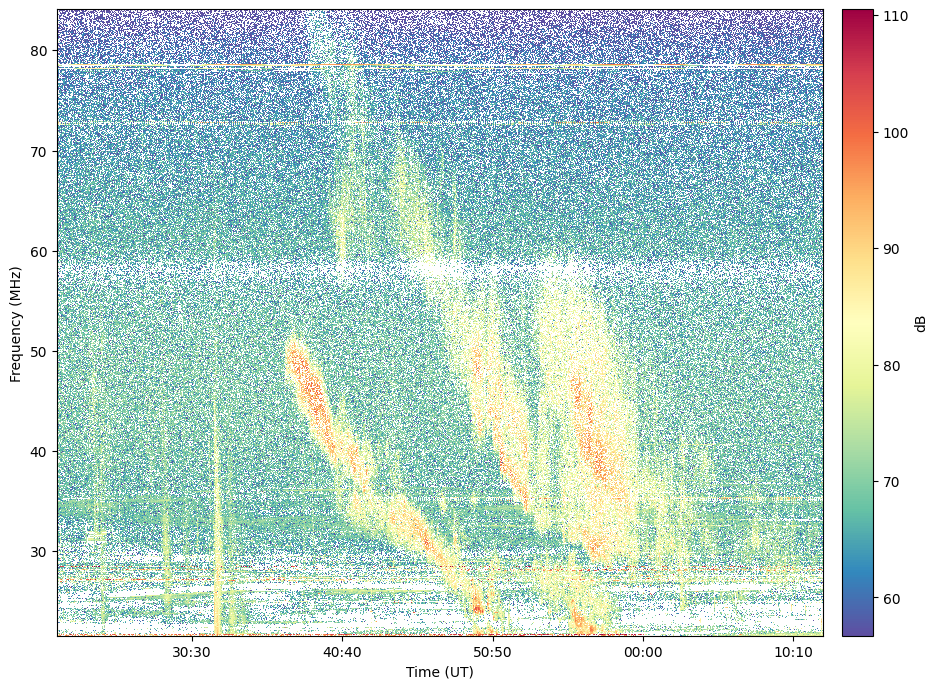

In [10]:
fig = plt.figure(figsize=[10,7])
ax = fig.add_subplot(111)
pc = ax.pcolormesh(df_combined.index, df_combined.columns, df_combined.T,
                   vmin=np.nanpercentile(df_combined, 7), vmax=np.nanpercentile(df_combined, 99.97),
                   shading='auto', cmap='Spectral_r')
fig.colorbar(pc, ax=ax, pad=0.02, label='dB')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis_date
ax.xaxis.set_major_formatter(mdates.DateFormatter('%M:%M'))
ax.set_xlabel('Time (UT)')
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))
# ax.set_xlabel(f'Time (MM:SS) starting from {low_times[0].time().hour}:00:00 UT')
fig.tight_layout()
plt.show()

In [11]:
# not actually the low-freq times, but in the above case, it's the times after remapping one dyspec to the other's grid.
# I just named it "low_times" to be able to use the codes below without repeating lines.
low_times      = df_combined.index
combined_freqs = df_combined.columns
combined_data  = df_combined.values

### Export the combined spectrum as a pickle file

In [ ]:
combined_output_path = f'/home/mnedal/outputs/data/combined_spectra_{low_times[0].date()}_stokes{stokes_param}_{what_is_this_spectrum}.pkl'

df_combined.to_pickle(combined_output_path)

# df_combined = pd.read_pickle(combined_output_path) # when importing the file

In [ ]:
# print(f'Difference in start times: {(high_times[0] - low_times[0]).total_seconds()*1e6} us')
# print(f'Difference in end times: {(high_times[-1] - low_times[-1]).total_seconds()*1e6} us')
# print(f'Low-freq time cadence: {np.diff(low_times)[0].total_seconds()*1e3:.2f} ms')
# print(f'High-freq time cadence: {np.diff(high_times)[0].total_seconds()*1e3:.2f} ms')

In [ ]:
# low_dt_us  = [ t.total_seconds()*1e6 for t in np.diff(low_times) ]
# high_dt_us = [ t.total_seconds()*1e6 for t in np.diff(high_times) ]

# low_dt_ms  = [ t.total_seconds()*1e3 for t in np.diff(low_times) ]
# high_dt_ms = [ t.total_seconds()*1e3 for t in np.diff(high_times) ]

In [ ]:
# combined_data  = np.concatenate((low_data_i.data, high_data_i.data), axis=1)
# combined_data  = np.squeeze(combined_data)
# combined_data  = 10 * np.log10(combined_data) # Convert the amplitude in decibels
# combined_freqs = np.concatenate((low_data_i.freq.to_value('MHz'), high_data_i.freq.to_value('MHz')))

In [ ]:
# # Save the combined data
# combined_output_path = f'/home/mnedal/outputs/data/combined_spectra_{low_times[0].date()}_{what_is_this_spectrum}.npz'
# np.savez(
#     combined_output_path,
#     data=combined_data,
#     time=low_times,
#     freq=combined_freqs
# )
# print(combined_output_path)

### Downsample NenuFAR dynamic spectrum to 1-second resolution
#### More practical for inspection

In [ ]:
# df_nenufar = pd.DataFrame(data=combined_data, index=low_times, columns=combined_freqs)
# df_nenufar.index.name = 'Time'
# df_nenufar.columns.name = 'Frequency'
# df_nenufar_1s = df_nenufar.resample('1S').mean()

In [ ]:
# fig = plt.figure(figsize=[10,7])
# ax = fig.add_subplot(111)
# pc = ax.pcolormesh(df_nenufar_1s.index, df_nenufar_1s.columns, df_nenufar_1s.values.T,
#                    vmin=np.nanpercentile(df_nenufar_1s, 7), vmax=np.nanpercentile(df_nenufar_1s, 99.97),
#                    shading='auto', cmap='Spectral_r')
# fig.colorbar(pc, ax=ax, pad=0.02, label='dB')
# ax.set_ylabel('Frequency (MHz)')
# ax.xaxis_date()
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))
# ax.set_xlabel(f'Time (MM:SS) starting from {low_times[0].time().hour}:00:00 UT')
# ax.set_title('Downsampled to 1-s data')
# fig.tight_layout()
# plt.show()

In [ ]:
# fig = plt.figure(figsize=[10,7])
# ax = fig.add_subplot(111)
# pc = ax.pcolormesh(low_times, combined_freqs, combined_data.T,
#                    vmin=np.nanpercentile(combined_data, 7), vmax=np.nanpercentile(combined_data, 99.97),
#                    shading='auto', cmap='Spectral_r') # Spectral_r, YlGnBu_r
# fig.colorbar(pc, ax=ax, pad=0.02, label='dB')
# ax.set_ylabel('Frequency (MHz)')
# ax.xaxis_date()
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))
# ax.set_xlabel(f'Time (MM:SS) starting from {low_times[0].time().hour}:00:00 UT')
# fig.tight_layout()
# plt.show()

In [ ]:
# # Comparison between the highres and downsampled data
# fig = plt.figure(figsize=[20,7])

# ax = fig.add_subplot(121)
# pc = ax.pcolormesh(df_nenufar.index, df_nenufar.columns, df_nenufar.values.T,
#                     shading='auto', cmap='Spectral_r')
# fig.colorbar(pc, ax=ax, pad=0.02, label='dB')
# ax.set_ylabel('Frequency (MHz)')
# ax.xaxis_date()
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))
# ax.set_xlabel(f'Time (MM:SS) starting from {low_times[0].time().hour}:00:00 UT')
# ax.set_title(f"Original time resolution {np.diff(df_nenufar.index)[0]/np.timedelta64(1, 'ms')} ms")

# ax = fig.add_subplot(122)
# pc = ax.pcolormesh(df_nenufar_1s.index, df_nenufar_1s.columns, df_nenufar_1s.values.T,
#                     shading='auto', cmap='Spectral_r')
# fig.colorbar(pc, ax=ax, pad=0.02, label='dB')
# ax.set_ylabel('Frequency (MHz)')
# ax.xaxis_date()
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))
# ax.set_xlabel(f'Time (MM:SS) starting from {low_times[0].time().hour}:00:00 UT')
# ax.set_title('Downsampled to 1-s data')

# fig.tight_layout()
# plt.show()

## Plot radio lightcurves

In [14]:
radio_lightcurves = {}
f_targets = [30, 40, 50, 60, 70, 80] # freq channels conisdered

for f_target in f_targets:
    # Find index of closest value
    f_index      = np.abs(combined_freqs - f_target).argmin()
    freq_channel = f'{round(combined_freqs[f_index])} MHz'
    radio_lightcurves[freq_channel] = combined_data[:, f_index]

print(radio_lightcurves.keys())

dict_keys(['30 MHz', '40 MHz', '50 MHz', '60 MHz', '70 MHz', '80 MHz'])


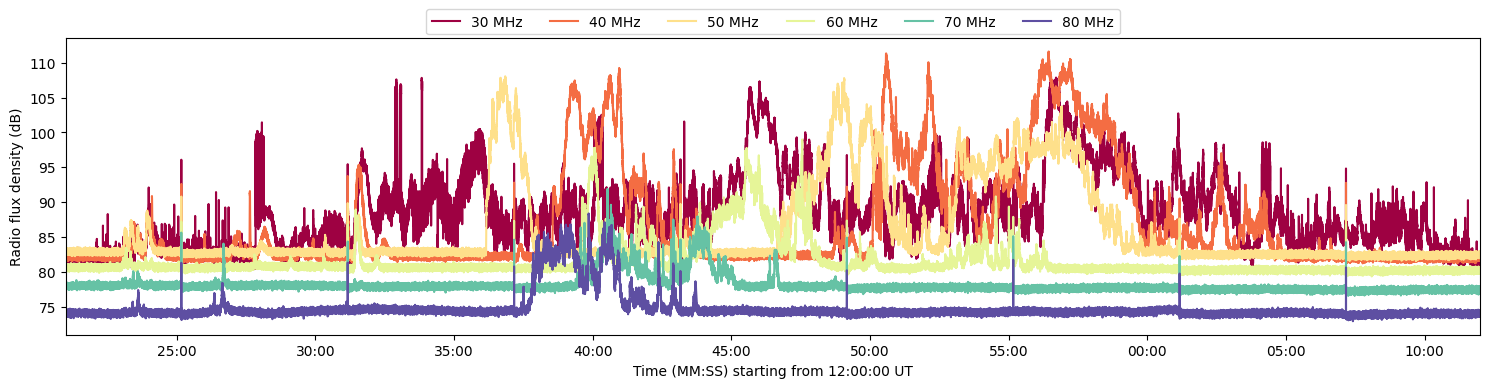

In [15]:
# Choose a colormap with many distinguishable colors
cmap        = plt.cm.get_cmap('Spectral')
num_lines   = len(radio_lightcurves.keys())
colors_list = cmap(np.linspace(0, 1, num_lines))

fig = plt.figure(figsize=[15,4])
ax = fig.add_subplot(111)

for i, key in enumerate(radio_lightcurves):
    ax.plot(low_times, radio_lightcurves[key], color=colors_list[i], label=key)

ax.legend(loc='best')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.12), ncol=num_lines)
# ax.legend(bbox_to_anchor=[1, 1])
ax.set_ylabel('Radio flux density (dB)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))
ax.set_xlabel(f'Time (MM:SS) starting from {low_times[0].time().hour}:00:00 UT')
ax.set_xlim(left=low_times[0], right=low_times[-1])
fig.tight_layout()
plt.show()

In [ ]:
# fig = plt.figure(figsize=[10, 7])
# ax = fig.add_subplot(111)

# # Plot the dynamic spectrum
# pc = ax.pcolormesh(low_times, combined_freqs, combined_data.T,
#                    vmin=60, vmax=125,
#                    shading='auto', cmap='Spectral_r')

# fig.colorbar(pc, ax=ax, label='dB')

# # Normalize the lightcurve to plot it visually on the frequency axis
# norm_curve = (radio_lightcurve - np.min(radio_lightcurve)) / (np.max(radio_lightcurve) - np.min(radio_lightcurve))
# freq_offset = 80  # e.g., 80 MHz
# freq_range = 5    # adjust vertical scaling

# ax.plot(low_times, freq_offset + norm_curve * freq_range, color='k', label='Lightcurve')

# # Labels and formatting
# ax.set_xlabel('Time (UT)')
# ax.set_ylabel('Frequency (MHz)')
# ax.xaxis_date()
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# fig.tight_layout()
# plt.legend()
# plt.show()

In [ ]:
# fig, ax1 = plt.subplots(figsize=[10,7])

# # Plot dynamic spectrum on the left y-axis
# pc = ax1.pcolormesh(low_times, combined_freqs, combined_data.T,
#                     vmin=np.nanpercentile(combined_data, 7), vmax=np.nanpercentile(combined_data, 99.97),
#                     shading='auto', cmap='Spectral_r')
# fig.colorbar(pc, ax=ax1, label='dB')

# ax1.set_ylabel('Frequency (MHz)')
# ax1.xaxis_date()
# ax1.xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))
# ax1.set_xlabel(f'Time (MM:SS) starting from {low_times[0].time().hour}:00:00 UT')

# # Plot the radio lightcurve on a secondary y-axis (right)
# ax2 = ax1.twinx()
# # ax2.plot(low_times, radio_lightcurve, color='k', label='Lightcurve')
# for i, key in enumerate(radio_lightcurves):
#     ax2.plot(low_times, radio_lightcurves[key], color=colors_list[i], label=key)
# ax2.set_ylabel('Radio Intensity (arbitrary units)', color='k')
# ax2.tick_params(axis='y', labelcolor='k')
# # ax2.set_xlim(left=low_times[0], right=low_times[-1])

# fig.tight_layout()
# plt.show()

## Plot the STIX HXR lightcurves

In [29]:
a.Time(low_times[0], low_times[-1])

<sunpy.net.attrs.Time(2025-03-25 12:20:59.998, 2025-03-25 13:11:59.994)>

In [30]:
sci_query = Fido.search(a.Time('2025-03-25 10:45:00', '2025-03-25 10:49:00'),#a.Time(low_times[0], low_times[-1]),
                        a.Instrument.stix, a.stix.DataType.sci)
display(sci_query)

Start Time,End Time,Instrument,Level,DataType,DataProduct,Ver,Request ID
str23,str23,str4,str2,str3,str13,str3,int64
2025-03-25 08:54:58.000,2025-03-25 15:00:15.000,STIX,L1,SCI,sci-xray-spec,V02,2503256095


In [31]:
sci_files = Fido.fetch(sci_query)
display(sci_files)

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

['/home/mnedal/sunpy/data/solo_L1_stix-sci-xray-spec_20250325T085458-20250325T150015_V02_2503256095-49356.fits']

In [32]:
spec = Product(sci_files)

if type(spec)==list:
    spec = spec[1]

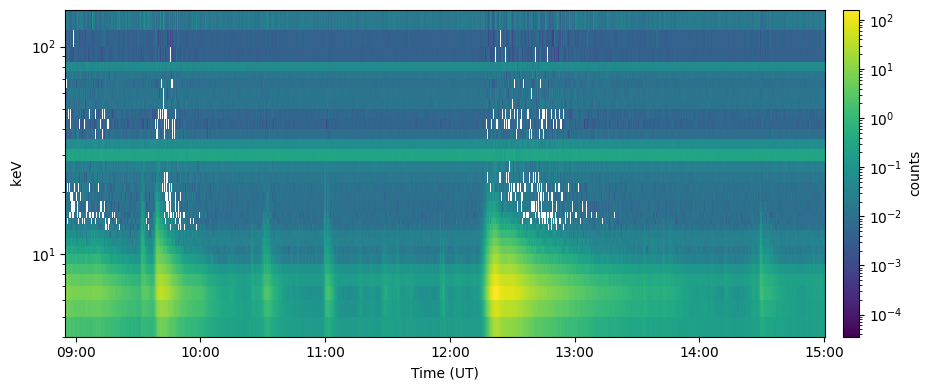

In [33]:
fig, ax = plt.subplots(figsize=[10,4])
spec.plot_spectrogram(axes=ax)
# Find the last QuadMesh artist added (likely your spectrogram)
im = [obj for obj in ax.get_children() if isinstance(obj, QuadMesh)][-1]
cbar = fig.colorbar(im, ax=ax, pad=0.02)
cbar.set_label(spec.meta['BUNIT'])
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_yscale('log')
ax.set_xlabel('Time (UT)')
# ax.set_xlim(left=low_times[0], right=low_times[-1])
fig.tight_layout()
plt.show()

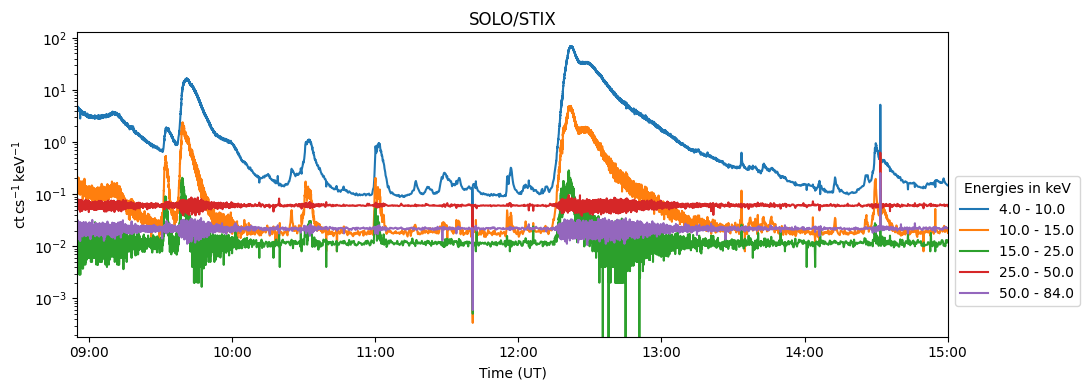

In [50]:
# Full STIX data
fig, ax = plt.subplots(figsize=[11,4])
spec.plot_timeseries(axes=ax, detector_indices=[[0,31]], pixel_indices=[[0,11]], energy_indices=[[1,6], [7,11], [12,16], [17,22], [23,27]])
ax.legend(bbox_to_anchor=(1, 0.55), title='Energies in keV')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# Prevent x-tick label rotation
plt.setp(ax.get_xticklabels(), rotation=0)
# Center-align the labels
for label in ax.get_xticklabels():
    label.set_horizontalalignment('center')

ax.set_xlim(left=spec.times[0].isot, right=spec.times[-1].isot)
ax.set_xlabel('Time (UT)')
ax.set_title(spec.meta['TELESCOP'])
fig.tight_layout()
plt.show()

In [34]:
# Time(Sun to Earth) - Time(Sun to S/C)
time_delay = spec.meta['EAR_TDEL']
dt = timedelta(seconds=time_delay)
print(time_delay, dt)

336.1486432712056 0:05:36.148643


In [21]:
# print(low_times[0] + dt, low_times[-1] + dt, sep='\n')

In [36]:
# display(spec.energies)

In [37]:
# # Sanity check ...
# e_channel = 4
# e_low     = spec.energies[spec.energies['channel']==e_channel]['e_low'][0].value
# e_high    = spec.energies[spec.energies['channel']==e_channel]['e_high'][0].value

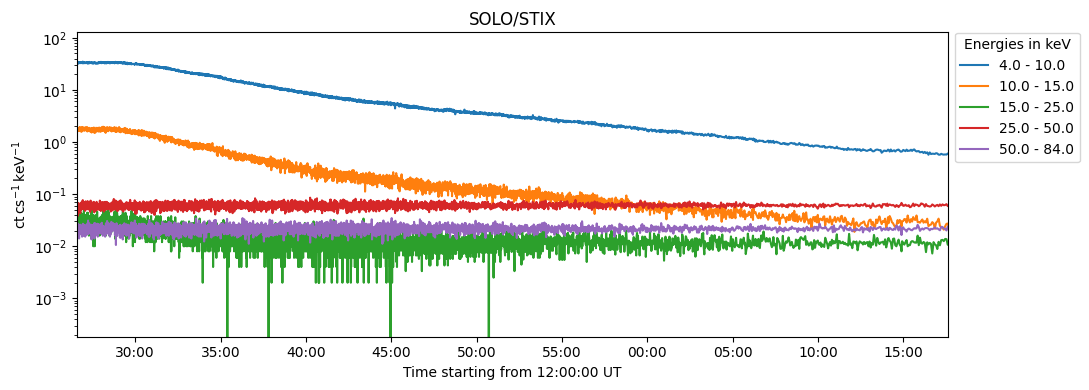

In [51]:
fig, ax = plt.subplots(figsize=[11,4])
spec.plot_timeseries(axes=ax, detector_indices=[[0,31]], pixel_indices=[[0,11]], energy_indices=[[1,6], [7,11], [12,16], [17,22], [23,27]])
ax.legend(bbox_to_anchor=(1, 0.55), title='Energies in keV')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# Prevent x-tick label rotation
plt.setp(ax.get_xticklabels(), rotation=0)
# Center-align the labels
for label in ax.get_xticklabels():
    label.set_horizontalalignment('center')

ax.set_xlim(left=low_times[0]+dt, right=low_times[-1]+dt)
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))
ax.set_xlabel(f'Time starting from {low_times[0].time().hour}:00:00 UT')
ax.set_title(spec.meta['TELESCOP'])
fig.tight_layout()
plt.show()

In [ ]:
# Step 1: Convert ISO strings to datetime objects
times_str = spec.times.isot
times_dt = np.array([datetime.fromisoformat(t) for t in times_str])

# Step 2: Calculate time differences between consecutive timestamps
dt_tmp = np.diff(times_dt)

# Step 3: Convert to seconds
cadence_seconds = np.array([td.total_seconds() for td in dt_tmp])

print(f'Min cadence: {np.min(cadence_seconds)} s')
print(f'Max cadence: {np.max(cadence_seconds)} s')
print(f'Mean cadence: {np.mean(cadence_seconds):.3f} s')

In [ ]:
plt.figure(figsize=[10,3])
plt.plot(cadence_seconds)
plt.xlabel('No. of samples')
plt.ylabel('Time cadence (s)')
plt.title(spec.meta['TELESCOP'])
plt.show()

---

In [ ]:
# from stixpy.timeseries import quicklook # This registers the STIX timeseries with sunpy

# ql_lightcurves = TimeSeries(ql_files)

In [ ]:
# fig, ax = plt.subplots(figsize=[10,4])
# ql_lightcurves.plot(axes=ax)
# ax.xaxis_date()
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))
# # Prevent x-tick label rotation
# plt.setp(ax.get_xticklabels(), rotation=0)
# # Center-align the labels
# for label in ax.get_xticklabels():
#     label.set_horizontalalignment('center')
# # ax.set_xlim(left=low_times[0], right=low_times[-1])

# dt = timedelta(minutes=5)
# ax.set_xlim(left=low_times[0]-dt, right=low_times[-1])
# ax.set_xlabel(f'Time starting from {low_times[0].time().hour}:00:00 UT')
# fig.tight_layout()
# plt.show()

In [ ]:
# print(ql_lightcurves.meta.metas[0]['keycomments']['EAR_TDEL'])
# for i, item in enumerate(ql_lightcurves.meta.metadata[0]):
#     if isinstance(item, dict) and 'EAR_TDEL' in item:
#         time_delay = item['EAR_TDEL']
#         print(time_delay)

In [ ]:
# fig, ax = plt.subplots(figsize=[10,4])
# ql_lightcurves.plot(axes=ax)
# ax.xaxis_date()
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))
# # Prevent x-tick label rotation
# plt.setp(ax.get_xticklabels(), rotation=0)
# # Center-align the labels
# for label in ax.get_xticklabels():
#     label.set_horizontalalignment('center')

# dt = timedelta(seconds=time_delay)
# ax.set_xlim(left=low_times[0]+dt, right=low_times[-1]+dt)
# ax.set_xlabel(f'Time starting from {low_times[0].time().hour}:00:00 UT')
# fig.tight_layout()
# plt.show()

In [ ]:
# df_stix = ql_lightcurves.to_dataframe()
# df_stix.head(3)

In [ ]:
# df_stix = df_stix.filter(items=['4-10 keV','10-15 keV','15-25 keV','25-50 keV','50-84 keV'])
# df_stix.head(3)

In [ ]:
# for col in df_stix:
#     print(col)

In [ ]:
# fig, ax = plt.subplots(figsize=[10,4])
# for col in df_stix:
#     ax.plot(df_stix.index, df_stix[col], label=col)
# ax.set_yscale('log')
# ax.legend()
# dt = timedelta(seconds=time_delay)
# ax.set_xlim(left=df_stix.index[0]+dt, right=df_stix.index[-1]+dt)
# ax.xaxis_date()
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))
# ax.set_xlabel(f'Time starting from {low_times[0].time().hour}:00:00 UT')
# fig.tight_layout()
# plt.show()

---

Troupleshooting

In [ ]:
# stokes_param = 'Q'
# low_data_q = Spectra(filename=low_freq_path)
# low_data_q = low_data_q.get(stokes=stokes_param, tmin=start_time, tmax=end_time, ignore_volume_warning=True)
# low_data_q.plot(figsize=figsize, title=f'Stokes {stokes_param}, default pipeline configuration')

In [ ]:
# stokes_param = 'U'
# low_data_u = Spectra(filename=low_freq_path)
# low_data_u = low_data_u.get(stokes=stokes_param, tmin=start_time, tmax=end_time, ignore_volume_warning=True)
# low_data_u.plot(figsize=figsize, title=f'Stokes {stokes_param}, default pipeline configuration')

In [ ]:
# stokes_param = 'V'
# low_data_v = Spectra(filename=low_freq_path)
# low_data_v = low_data_v.get(stokes=stokes_param, tmin=start_time, tmax=end_time, ignore_volume_warning=True)
# low_data_v.plot(figsize=figsize, title=f'Stokes {stokes_param}, default pipeline configuration')

In [ ]:
# u_i = low_data_u.data/low_data_i.data
# u_i = np.squeeze(u_i)
# freqs = low_data_i.freq.to_value('MHz')
# times = np.array([datetime.utcfromtimestamp(t) for t in low_data_i.time.unix])

# fig = plt.figure(figsize=[7,4])
# ax = fig.add_subplot(111)
# pc = ax.pcolormesh(times, freqs, u_i.T,
#                     vmin=-0.5, vmax=0.5,
#                     shading='auto', cmap='seismic')
# fig.colorbar(pc, ax=ax, label='degree of U/I')
# ax.set_xlabel('Time (UT)')
# ax.set_ylabel('Frequency (MHz)')
# ax.xaxis_date()
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# fig.tight_layout()
# plt.show()

## Load the NenuFAR dynamic spectrum as dataframe

In [67]:
df = pd.read_pickle('/home/mnedal/outputs/data/combined_spectra_2025-03-25_typeII.pkl')
df.head(3)

Frequency,21.582031,21.588135,21.594238,21.600342,21.606445,21.612549,21.618652,21.624756,21.630859,21.636963,...,84.020996,84.027100,84.033203,84.039307,84.045410,84.051514,84.057617,84.063721,84.069824,84.075928
Time,,,,,,,,,,,,,,,,,,,,,
2025-03-25 12:20:59.997704,114.552837,102.689649,105.854383,100.147996,105.648060,120.648026,119.135116,99.519773,86.703942,86.905673,...,68.692938,68.618866,68.459585,68.692334,68.789845,68.636228,68.609715,68.315909,68.001920,68.345426
2025-03-25 12:21:00.018675,115.122050,103.228349,105.693661,99.956677,105.797276,120.860704,119.331725,99.612935,86.114320,86.913112,...,68.837266,68.636307,68.382802,68.266905,68.345966,68.220413,68.406872,68.238065,68.325751,68.578852
2025-03-25 12:21:00.039647,115.301723,102.926153,105.099000,99.340611,106.708872,121.706330,120.190096,100.537896,86.222454,86.548376,...,68.614979,68.575463,68.497894,68.324464,68.412827,68.761003,68.698386,68.517237,68.568357,68.899609


### Downsample to 1-second resolution for practical visualization

In [68]:
df_1s = df.resample('1S').mean()

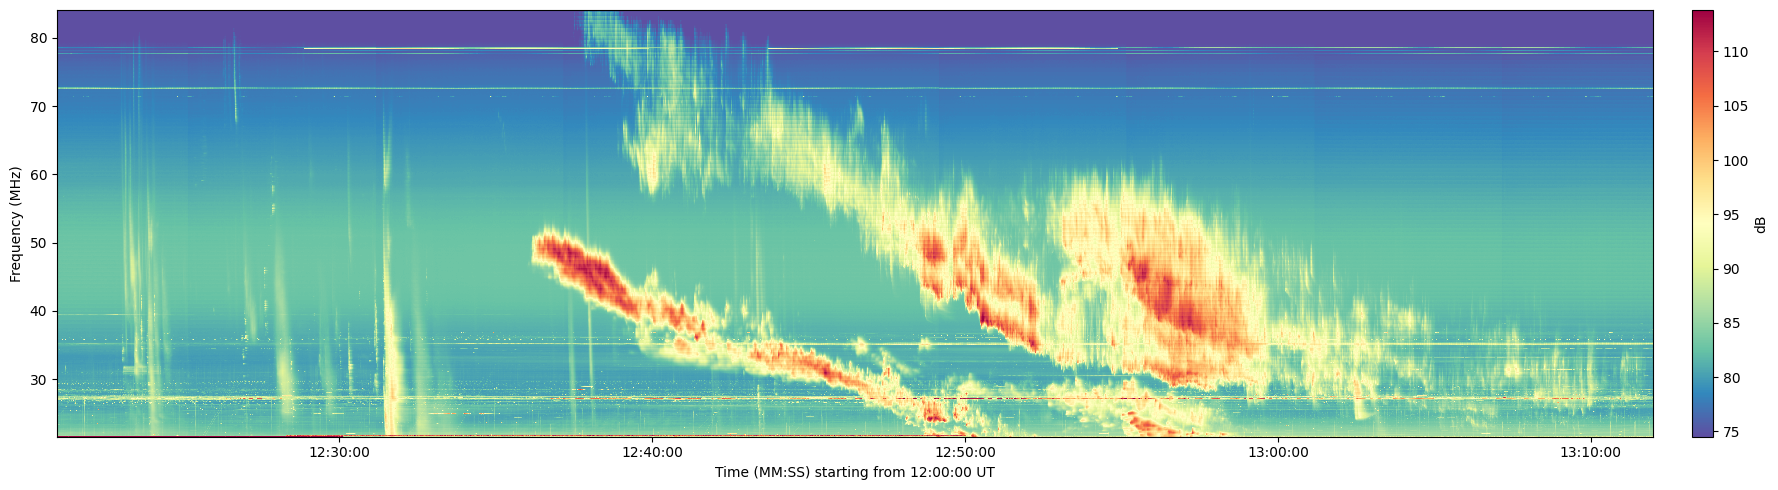

In [73]:
fig = plt.figure(figsize=[20,5])
ax = fig.add_subplot(111)
pc = ax.pcolormesh(df_1s.index, df_1s.columns, df_1s.T,
                   vmin=np.nanpercentile(df_1s, 7), vmax=np.nanpercentile(df_1s, 99.97),
                   shading='auto', cmap='Spectral_r')
fig.colorbar(pc, ax=ax, pad=0.02, label='dB')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax.set_xlabel(f'Time (MM:SS) starting from {df_1s.index[0].time().hour}:00:00 UT')
fig.tight_layout()
plt.show()

In [74]:
# Remove constant background
df_new = df_1s - np.tile(np.mean(df_1s,0), (df_1s.shape[0],1))

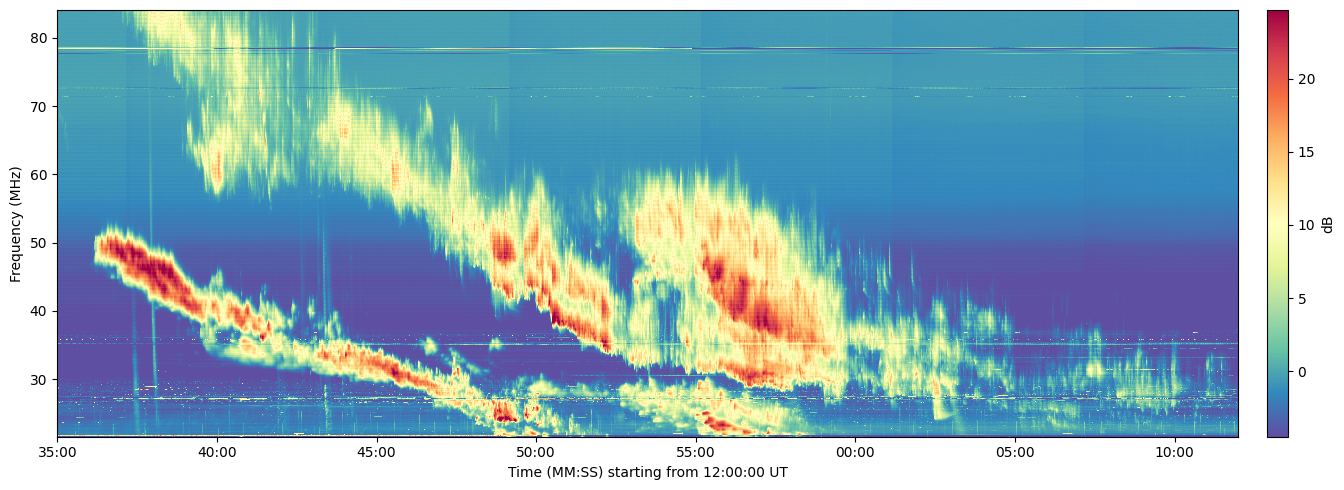

In [97]:
# fig = plt.figure(figsize=[10,7])
fig = plt.figure(figsize=[15,5])
ax = fig.add_subplot(111)
pc = ax.pcolormesh(df_new.index, df_new.columns, df_new.T,
                   vmin=np.nanpercentile(df_new, 7),
                   vmax=np.nanpercentile(df_new, 99.97),
                   shading='auto', cmap='Spectral_r')
fig.colorbar(pc, ax=ax, pad=0.02, label='dB')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))
ax.set_xlim(left=df_new.index[0] + timedelta(minutes=14))
ax.set_xlabel(f'Time (MM:SS) starting from {df_new.index[0].time().hour}:00:00 UT')
fig.tight_layout()
plt.show()